<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

## Подготовка

In [144]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [145]:
data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])

In [146]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [147]:
data = data.resample('1H').sum()

In [148]:
data_week = data.resample('1D').sum()

## Анализ

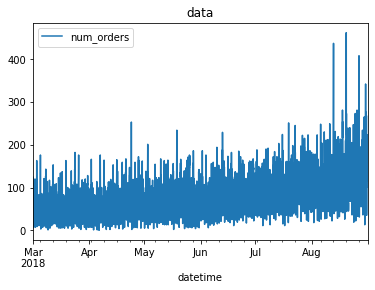

In [149]:
data.plot(title='data');

In [150]:
data.describe()

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


In [151]:
data.isna().sum()

num_orders    0
dtype: int64

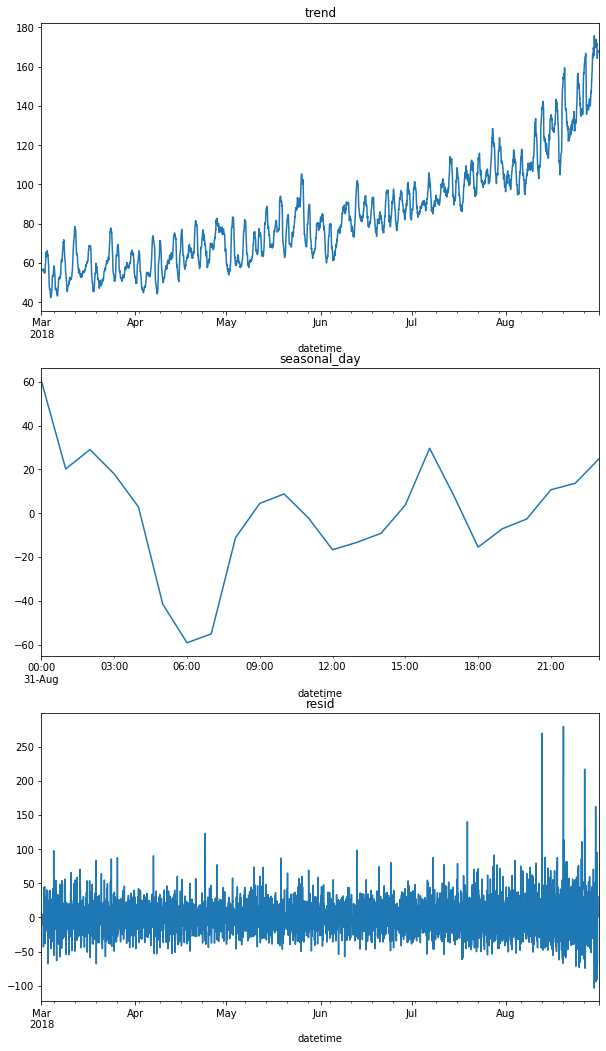

In [152]:
decomposed = seasonal_decompose(data)
plt.figure(figsize=(10, 18))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca(), title='trend'); # тренд
plt.subplot(312)
decomposed.seasonal.tail(24).plot(ax=plt.gca(), title='seasonal_day'); # сезонная составляющая
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca(), title='resid');

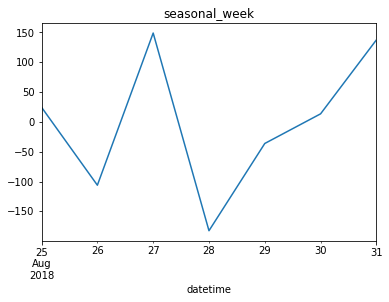

In [153]:
decomposed = seasonal_decompose(data_week)
decomposed.seasonal.tail(7).plot(ax=plt.gca(), title='seasonal_week');

***Выводы:***

После анализа данных я пришла к выводу, что у нас суточная и недельная сезонности. В течение дня максимум в 00:00, а минимум в 6:00, а на неделе (от 0 до 6 дни) 2 и 6 дни - пик, а минимум на середине недели.

Общий тренд ряда восходящий с ускорением, начиная с мая.

К концу графика количество "остатков" немного больше.

## Обучение

In [154]:
def make_features(data, max_lag, rolling_mean_size):
    data['hour'] = data.index.hour
    data['dayofweek'] = data.index.dayofweek
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [155]:
def rmse(target, predict):
    return mean_squared_error(target, predict) ** 0.5

In [156]:
make_features(data, 168, 5)
train, test = train_test_split(data, shuffle=False, test_size=0.1)
train = train.dropna()
        
train_features = train.drop(['num_orders'], axis=1)
train_target = train['num_orders']

test_features = test.drop(['num_orders'], axis=1)
test_target = test['num_orders']

In [157]:
scorer = make_scorer(rmse, greater_is_better=False)
model = LinearRegression()
tscv = TimeSeriesSplit(n_splits=5)
gsearch = GridSearchCV(estimator=model, cv=tscv, param_grid={}, scoring=scorer)
gsearch.fit(train_features, train_target)
gsearch.best_score_ * (-1)

22.54420030682363

In [159]:
%%time
model = DecisionTreeRegressor()
tscv = TimeSeriesSplit(n_splits=5)
gsearch_tree = GridSearchCV(estimator=model, cv=tscv, param_grid={}, scoring=scorer)
gsearch_tree.fit(train_features, train_target)
gsearch_tree.best_score_ * (-1)
# Wall time: 1.69 s

CPU times: user 1.65 s, sys: 4 ms, total: 1.65 s
Wall time: 1.65 s


33.48953964093256

In [160]:
%%time
model = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=5)
grid_forest = GridSearchCV(model, param_grid={'max_depth': range(1, 20), 'n_estimators': range(10, 31, 10)},
                           scoring=scorer, cv=tscv)
grid_forest.fit(train_features, train_target)
grid_forest.best_score_ * (-1)
# Wall time: 8min 16s

CPU times: user 8min 21s, sys: 1.24 s, total: 8min 22s
Wall time: 8min 22s


23.021540627588983

***Выводы:***

Наилучшие результаты показывают линейная регрессия и модель случайного леса регрессии, далее я проверю обе модели на тестовых данных.

## Тестирование

In [161]:
model = RandomForestRegressor(n_estimators=grid_forest.best_params_['n_estimators'],
                              max_depth=grid_forest.best_params_['max_depth'], random_state=12345)
model.fit(train_features, train_target)
predictions = model.predict(test_features)
rmse(test_target, predictions)
# lag = 48 => 41.6410462054079
# lag = 168 => 40.446730120117934

40.446730120117934

In [162]:
model = LinearRegression()
model.fit(train_features, train_target)
predictions = model.predict(test_features)
rmse(test_target, predictions)
# lag = 48 => 41.8466243964101
# lag = 168 => 34.524978081615984

34.524978081615984

После добавления признака дня недели метрика улучшилась на 0.004

***Вывод:***

Лучше всего себя показала модель линейной регрессии. Когда количество лагов было = 48, лес и линейная регрессия показывали примерно одинаковый результат 41.7, но когда я увеличила количество лагов до 168, результат леса не сильно улучшился (40.4), а вот линейная регрессия показала наилучший результат 34.5.